In [1]:
import xml.etree.ElementTree as ET 
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

master = pd.read_csv(os.getcwd() + "/Resources/RugbyHub_master_data.csv",dtype=str)

#PLID,TEAMIDのインポート
psheets = ["PLID", "TID", "Venue"]
ptid = pd.read_excel(os.getcwd() +"/Resources/Japan Rugby League One Player ID.xlsx", sheet_name = psheets,dtype=str)
tid = pd.DataFrame(ptid["TID"])
venue = pd.DataFrame(ptid["Venue"])
plid = pd.DataFrame(ptid["PLID"])

# XMLファイルを解析
tree = ET.parse('/Users/isakakou/Desktop/933699_SUNTvNECG_final_whistle_superscout.xml') 

# XMLを取得
root = tree.getroot()
df = pd.DataFrame(index=[],columns = ['ID','FXID','PLID','team_id','ps_timestamp','ps_endstamp','MatchTime','psID','period',
           'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
           'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum',
           'sequence_id','player_advantage','score_advantage','flag','advantage','assoc_player'])

for action in root.iter('ActionRow'):
    s = pd.Series([action.get('ID'),action.get('FXID'),action.get('PLID'),action.get('team_id'),
                   action.get('ps_timestamp'),action.get('ps_endstamp'),action.get('MatchTime'),action.get('psID'),
                   action.get('period'),action.get('x_coord'),action.get('y_coord'),action.get('x_coord_end'),action.get('y_coord_end'),
                   action.get('action'),action.get('ActionType'),action.get('Actionresult'),action.get('qualifier3'),
                   action.get('qualifier4'),action.get('qualifier5'),action.get('Metres'),action.get('PlayNum'),action.get('SetNum'),
                   action.get('sequence_id'),action.get('player_advantage'),action.get('score_advantage'),action.get('flag'),
                   action.get('advantage'),action.get('assoc_player')], index = df.columns)
    df = df.append(s, ignore_index=True)

df[['x_coord', 'y_coord']] = df[['x_coord', 'y_coord']].astype(np.uint8)

df.qualifier3 = df.qualifier3.map(master.set_index('ID').Definition)
df.qualifier4 = df.qualifier4.map(master.set_index('ID').Definition)
df.qualifier5 = df.qualifier5.map(master.set_index('ID').Definition)
df.Actionresult = df.Actionresult.map(master.set_index('ID').Definition)
df.ActionType = df.ActionType.map(master.set_index('ID').Definition)
df.action = df.action.map(master.set_index('ID').Definition)

df.team_id = df.team_id.map(tid.set_index('team_id').team_name)
df.PLID = df.PLID.map(plid.set_index('players_id').player_known_name)
# df.to_csv('/Users/isakakou/Desktop/933693_NECGvKINT_final_whistle_superscout.csv', header=True, index=False)

# Ruck Speed

qualifier4  0-1 Seconds  1-2 Seconds  2-3 Seconds  3-4 Seconds  4-5 Seconds  \
action                                                                        
Ruck                  1           16           12            3            3   
All                   1           16           12            3            3   

qualifier4  6+ Seconds  N/A Ruck Speed  All  
action                                       
Ruck                 5              11   51  
All                  5              11   51  


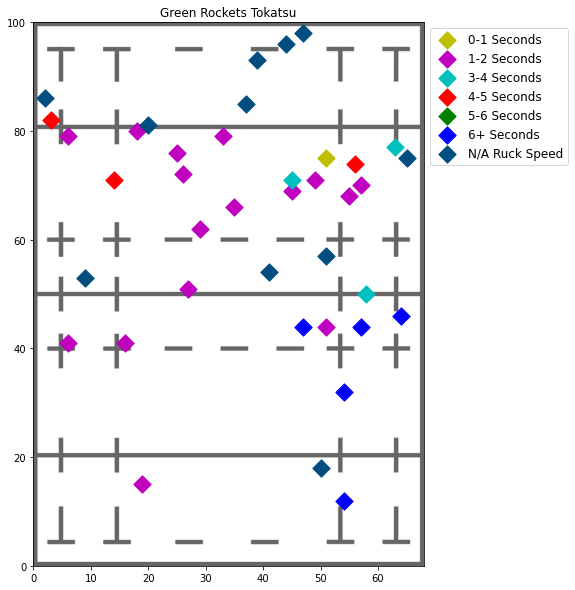

In [4]:
TEAMNAME = 'Green Rockets Tokatsu'
dfaction = df.loc[(df['team_id'] == TEAMNAME)]

dfaction = dfaction.loc[dfaction['action'] == 'Ruck']
rspeed = ['0-1 Seconds','1-2 Seconds','3-4 Seconds','4-5 Seconds','5-6 Seconds','6+ Seconds', "N/A Ruck Speed"]
cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
fig = plt.figure(figsize=(7, 10))
ax = fig.add_subplot(1, 1,1)
plt.xlim(0, 68)
plt.ylim(0,100)

a = pd.crosstab(dfaction['action'],dfaction['qualifier4'],margins=True)
a.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Ruck Speed.csv')
print(a)

#背景画像の設定
fig.patch.set_facecolor('white')
im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

for i in range(len(rspeed)):
    r = dfaction.loc[dfaction['qualifier4'] == rspeed[i]]
    plt.scatter(r['y_coord'], r["x_coord"], label=rspeed[i] ,marker = 'D',color=cl[i], s=150)

#ラベルの表示
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
plt.title(TEAMNAME)
plt.gcf().subplots_adjust(wspace=4)

In [3]:
dfaction = df.loc[(df['team_id'] == TEAMNAME)]

players = dfaction.drop_duplicates(subset=['PLID'],keep='first')
player_list = players['PLID']
player_list = player_list.reset_index(drop=True)
carry_meter = pd.DataFrame()

for i in range(len(player_list)):
    player_dfaction = dfaction.loc[dfaction['PLID'] == player_list[i]]
    carry = player_dfaction.loc[player_dfaction['action'] == 'Carry']
    carry_list = carry['Metres'].astype(int)
    s = pd.Series([player_list[i],carry_list.sum()], index = ['Name','Metres'])
    carry_meter = carry_meter.append(s, ignore_index=True)

carry_meter
carry_meter.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Carry_Meter.csv')